# Training XGBoost to Emulate ec-land

In this notebook we take some example Zarr data (similar to that created by this projects other functionality) and train an ML emulator of the ec-land land surface model. Here we are training on features of climatological, meteorological and previous model state values to predict the 6-hourly model state update 

In [1]:
import xarray as xr
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error


def r2_score_multi(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """Calculated the r-squared score between 2 arrays of values

    :param y_pred: predicted array
    :param y_true: "truth" array
    :return: r-squared metric
    """
    return r2_score(y_pred.flatten(), y_true.flatten())

Open up the mock data zarr file and select a couple of years for training the ML model...

In [2]:
# Open up the Zarr data
ds_ecland = xr.open_zarr("../tests/mock_data/ecland_cy49r2_2020_2022.zarr").sel(time=slice("2020", "2021"))
# Inspect the concatenated dataset and see available model variables
ds_ecland

<xarray.Dataset>
Dimensions:      (time: 2924, x: 10)
Coordinates:
    lat          (x) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    lon          (x) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2020-01-01 ... 2021-12-31T18:00:00
  * x            (x) int32 60870 60871 60872 60873 ... 60876 60877 60878 60879
Data variables: (12/37)
    aco2gpp      (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    clim_CLAKE   (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    clim_Ctype   (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    clim_cu      (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    clim_cvh     (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    clim_cvl     (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    ...           ...
    stl1         (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    stl2         (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    stl3         (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    swvl1        (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    swvl2        (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
    swvl3        (time, x) float32 dask.array<chunksize=(2924, 10), meta=np.ndarray>
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF

Next we select the "features" and "targets" that we want to use to use in the construction of our ML model. The we select this subset of variables from the dataset

In [3]:
feat_lst = [
            'clim_CLAKE',
            'clim_Ctype',
            'clim_cu',
            'clim_cvh',
            'clim_cvl',
            'clim_geopot',
            'clim_sdfor',
            'clim_sdor',
            'clim_sotype',
            'clim_tvh',
            'clim_tvl',
            'clim_z0m',
            'lai_hv', 
            'lai_lv', 
            'met_ctpf',
            'met_lwdown',
            'met_psurf',
            'met_qair',
            'met_rainf',
            'met_swdown',
            'met_snowf',
            'met_tair',
            'met_wind_e',
            'met_wind_n',
            'swvl1',
            'swvl2',
            'swvl3',
            'stl1',
            'stl2',
            'stl3',
            'snowc',
           ]

targ_lst = ['swvl1',
            'swvl2',
            'swvl3',
            'stl1',
            'stl2',
            'stl3',
            'snowc',
           ]

# Shift the times of the features/targets so that from the previous state we are predicting the next state
feats_ds = ds_ecland.isel(time=slice(0,-1))
target_ds = ds_ecland.isel(time=slice(1,None))

# Select the desired variables, convert to an array, stack the 'time' and 'space' dimensions. 
# For the targets we minus the previous value of the model state so that we are predicting 
# the 6-hourly model update increments instead of the next absolutle model value.
feats_ds = feats_ds[feat_lst].to_array().astype("float32").stack(z=("x", "time",)).transpose()
target_ds = target_ds[targ_lst].to_array().astype("float32").stack(z=("x", "time",)).transpose() - feats_ds[:, -len(targ_lst):].values

In [4]:
# inspect the feautre dataset
feats_ds

<xarray.DataArray (z: 29230, variable: 31)>
dask.array<transpose, shape=(29230, 31), dtype=float32, chunksize=(29230, 1), chunktype=numpy.ndarray>
Coordinates:
    lat       (z) float32 dask.array<chunksize=(29230,), meta=np.ndarray>
    lon       (z) float32 dask.array<chunksize=(29230,), meta=np.ndarray>
  * variable  (variable) object 'clim_CLAKE' 'clim_Ctype' ... 'stl3' 'snowc'
  * z         (z) object MultiIndex
  * x         (z) int32 60870 60870 60870 60870 ... 60879 60879 60879 60879
  * time      (z) datetime64[ns] 2020-01-01 ... 2021-12-31T12:00:00
Attributes:
    CONVERTED:     from grib files with grib_api
    GRID_POINTS:  gaussian grid 
    SOURCE:       ECMWF

## Model training with XGBoost

Now we have our "features" and "targets" we can train xgboost to predict our model increments.

In [5]:
%%time
# Set feaures and targets
X = feats_ds.values
y = target_ds.values

# Setup the xgboost model instance and choose some parameters to control the training
model = xgb.XGBRegressor(
    n_estimators=128,
    tree_method="hist",
    objevtive=mean_absolute_error,
    # multi_strategy="multi_output_tree",
    # learning_rate=0.3,
    eval_metric=r2_score_multi,
    subsample=0.6,
)

print("Fitting XGB model...")
model.fit(X, y, eval_set=[(X, y)])

Fitting XGB model...
[0]	validation_0-rmse:1.19889	validation_0-r2_score_multi:0.19423
[1]	validation_0-rmse:1.04874	validation_0-r2_score_multi:0.38343
[2]	validation_0-rmse:0.92743	validation_0-r2_score_multi:0.51782
[3]	validation_0-rmse:0.84049	validation_0-r2_score_multi:0.60399
[4]	validation_0-rmse:0.78368	validation_0-r2_score_multi:0.65571
[5]	validation_0-rmse:0.73875	validation_0-r2_score_multi:0.69406
[6]	validation_0-rmse:0.70419	validation_0-r2_score_multi:0.72201
[7]	validation_0-rmse:0.67523	validation_0-r2_score_multi:0.74441
[8]	validation_0-rmse:0.65007	validation_0-r2_score_multi:0.76310
[9]	validation_0-rmse:0.62717	validation_0-r2_score_multi:0.77950
[10]	validation_0-rmse:0.61183	validation_0-r2_score_multi:0.79015
[11]	validation_0-rmse:0.59080	validation_0-r2_score_multi:0.80433
[12]	validation_0-rmse:0.57810	validation_0-r2_score_multi:0.81265
[13]	validation_0-rmse:0.56153	validation_0-r2_score_multi:0.82324
[14]	validation_0-rmse:0.55146	validation_0-r2_scor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function r2_score_multi at 0x147d9960e0e0>,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=128, n_jobs=None,
             num_parallel_tree=None,
             objevtive=<function mean_absolute_error at 0x147d5bafcaf0>,
             predictor=None, ...)

## Testing the newly trained emulator

Now that we have our trained ML model we can test it against some independent data. We open up the ML training database and then apply the model over a complete three year period to test how well it performs. The last year here (2022) is completely independent having not been used in the training.

In [6]:
# Open the test data and select a single point in space to run the model on
ds_test = xr.open_zarr("../tests/mock_data/ecland_cy49r2_2020_2022.zarr")
feats = ds_test[feat_lst].isel(x=5, time=slice(0,-1))

In [7]:
# Transform xr.Dataset into a np.ndarray
feats_arr = feats[feat_lst].to_array().values.T

In [8]:
# Run the model for a single time to check it works and gives us the desired size output
model.predict(feats_arr[[1]])

array([[-1.4770023e-03, -9.6139690e-04, -1.5946946e-04,  1.4598068e+00,
        -1.6665083e-01, -6.8013445e-02, -4.0035928e-03]], dtype=float32)

In [9]:
%%time
# Loop over all times and iteratively apply the ML model to construct a 3-year ML estimate to the ec-land model
for x in range(len(feats_arr)-1):
    if x % 1000 == 0:
        print(f"on step {x}...")
    preds = model.predict(feats_arr[[x]])
    feats_arr[x+1, -len(targ_lst):] = np.clip(feats_arr[x, -len(targ_lst):] + preds, 0, None)

on step 0...


on step 1000...
on step 2000...
on step 3000...
on step 4000...
CPU times: user 1.73 s, sys: 74.2 ms, total: 1.8 s
Wall time: 1.82 s


## Plotting the results

Now we have 3-year's of output from the ec-land model and from our ML emulator, "ai-land", we can plot both trajectories to see how the ML model performs. As it has been trained on the first 2-years we expect it to fit here. However, the final year was left out of training and so is independent, we see the ML model still performs very well even in this independent year. 

It is also worth noting that here we have performed a complete 3-year run with the "ai-land" model (~4300 applications) and we find very little compounding errors, allowing us to accurately capture the full ec-land climatology.

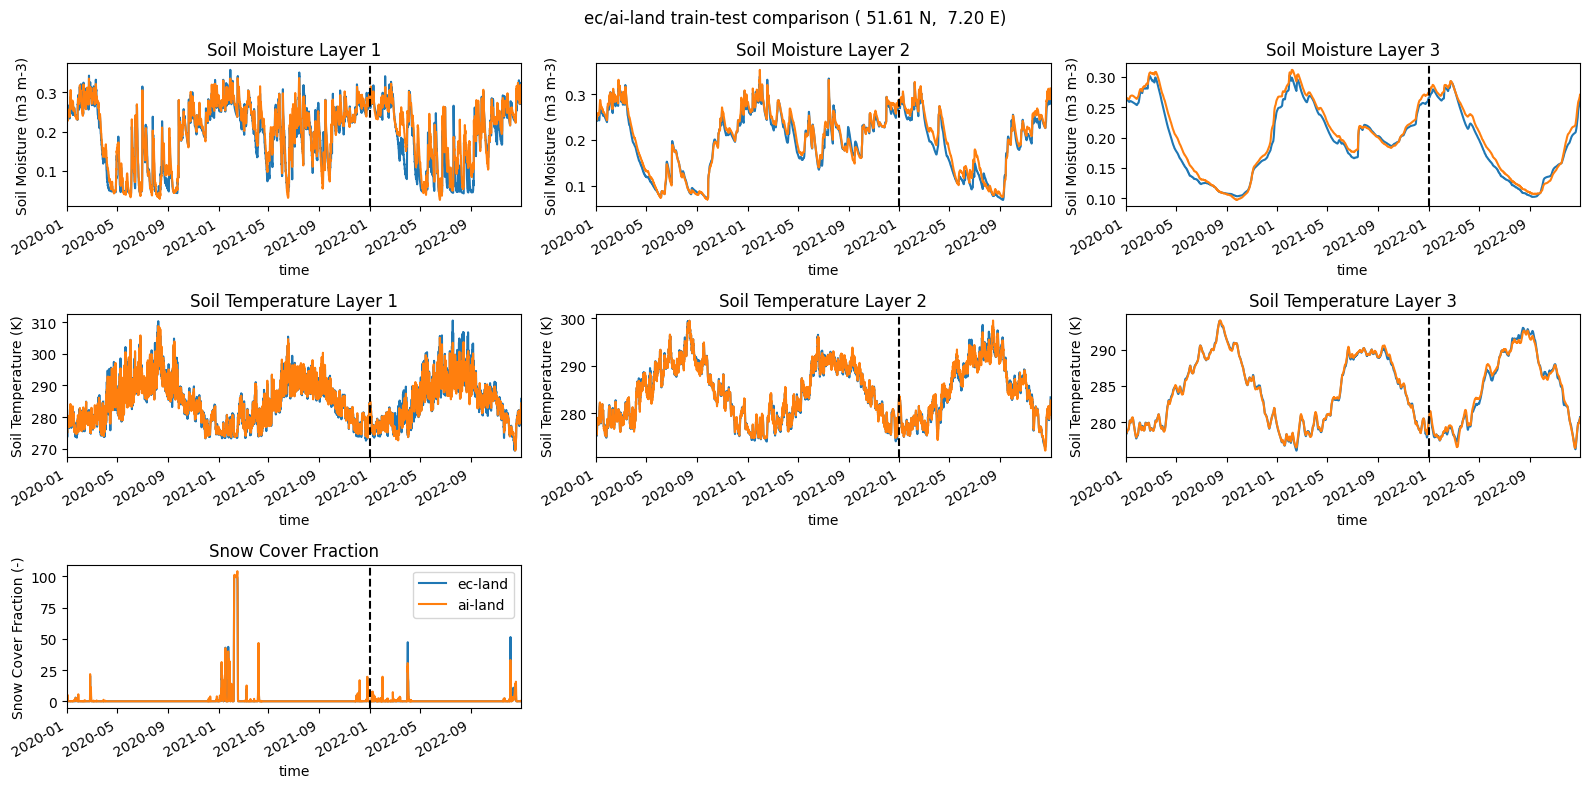

In [10]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(331)
ax2 = plt.subplot(332)
ax3 = plt.subplot(333)
ax4 = plt.subplot(334)
ax5 = plt.subplot(335)
ax6 = plt.subplot(336)
ax7 = plt.subplot(337)

def ailand_plot(var_name, ax, ylabel, ax_title, test_date="2022-01-01"):
    """Plotting function for the ec-land database and ai-land model output

    :param var_name: parameter variable name
    :param ax: the axes to plot on
    :param ylabel: y-label for plot
    :param ax_title: title for plot
    :param test_date: date to plot vertical line (train/test split), defaults to "2022-01-01"
    :return: plot axes
    """
    feats[var_name].plot(label="ec-land", ax=ax)
    ax.plot(feats.time, feats_arr[:, feat_lst.index(var_name)], label="ai-land")
    ax.axvline(feats.sel(time=test_date).time.values[0], color="k", linestyle="--")
    ax.set_xlim(feats.time.values[[0,-1]])
    ax.set_ylabel(ylabel)
    ax.set_title(ax_title)
    return ax

ailand_plot("swvl1", ax1, "Soil Moisture (m3 m-3)", "Soil Moisture Layer 1")
ailand_plot("swvl2", ax2, "Soil Moisture (m3 m-3)", "Soil Moisture Layer 2")
ailand_plot("swvl3", ax3, "Soil Moisture (m3 m-3)", "Soil Moisture Layer 3")
ailand_plot("stl1", ax4, "Soil Temperature (K)", "Soil Temperature Layer 1")
ailand_plot("stl2", ax5, "Soil Temperature (K)", "Soil Temperature Layer 2")
ailand_plot("stl3", ax6, "Soil Temperature (K)", "Soil Temperature Layer 3")
ailand_plot("snowc", ax7, "Snow Cover Fraction (-)", "Snow Cover Fraction")

plt.legend()
fig.suptitle(f"ec/ai-land train-test comparison ({feats.lat.values: .2f} N, {feats.lon.values: .2f} E)")
fig.tight_layout()
# fig.savefig("../docs/images/ec-ai-land_comp.png", bbox_inches="tight")